In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from google.colab import drive
import kagglehub

path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
directory = path+ '/Data/images_original'

100%|██████████| 1.21G/1.21G [00:24<00:00, 53.4MB/s]

Extracting files...


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])
dataset = datasets.ImageFolder(root=directory, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
test_size = val_size // 2
val_size -= test_size
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
class GenreClassifier(nn.Module):
  def __init__(self):
    super(GenreClassifier, self).__init__()
    self.network = models.resnet50(pretrained=True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 10)
  def forward(self, x):
    return self.network(x)


In [4]:
model = GenreClassifier()
# Freeze layers outside of the class definition
for param in model.network.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in model.network.fc.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.network.fc.parameters(), lr=0.001)

In [6]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):

        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

Epoch [1/10], Train Loss: 2.2027, Train Accuracy: 24.46%, Val Loss: 1.9470, Val Accuracy: 24.67%
Epoch [2/10], Train Loss: 1.6903, Train Accuracy: 46.78%, Val Loss: 1.5672, Val Accuracy: 46.67%
Epoch [3/10], Train Loss: 1.4542, Train Accuracy: 54.65%, Val Loss: 1.4107, Val Accuracy: 56.00%
Epoch [4/10], Train Loss: 1.3037, Train Accuracy: 59.37%, Val Loss: 1.4494, Val Accuracy: 46.67%
Epoch [5/10], Train Loss: 1.2364, Train Accuracy: 60.09%, Val Loss: 1.3455, Val Accuracy: 54.00%
Epoch [6/10], Train Loss: 1.0988, Train Accuracy: 67.10%, Val Loss: 1.2833, Val Accuracy: 56.00%
Epoch [7/10], Train Loss: 1.0583, Train Accuracy: 66.67%, Val Loss: 1.2188, Val Accuracy: 56.00%
Epoch [8/10], Train Loss: 0.9863, Train Accuracy: 69.96%, Val Loss: 1.2522, Val Accuracy: 52.67%
Epoch [9/10], Train Loss: 0.9434, Train Accuracy: 72.39%, Val Loss: 1.2066, Val Accuracy: 56.00%
Epoch [10/10], Train Loss: 0.9269, Train Accuracy: 72.53%, Val Loss: 1.1799, Val Accuracy: 58.00%


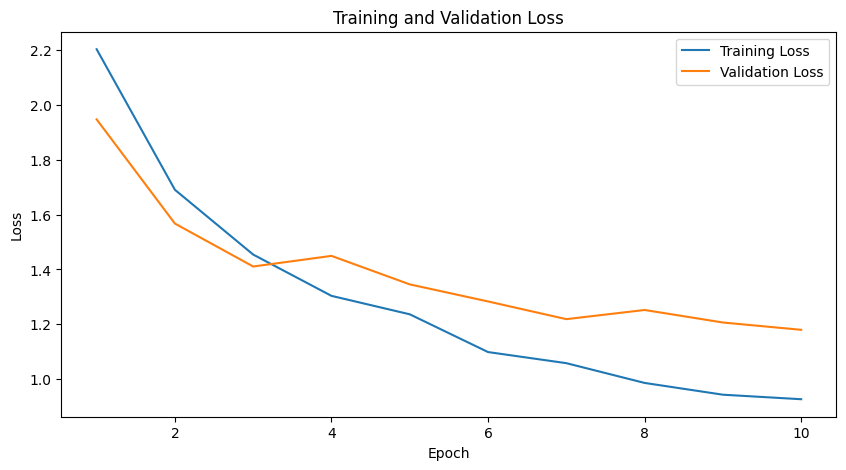

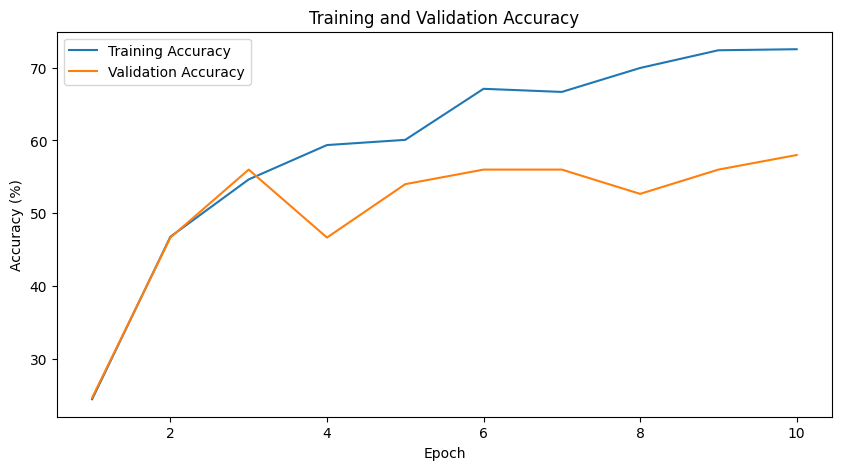

In [7]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)